In [29]:
import os
import random
import numpy as np
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, TimeDistributed, Flatten, Bidirectional, BatchNormalization, SpatialDropout1D, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from scipy.signal import butter, filtfilt, wiener
from scipy import signal
from sklearn.decomposition import FastICA

In [30]:
angry_path = os.path.expanduser('/home/mahin/Documents/notebook/Multimodal-Emotion-Recognition/Datasets/Speech/Angry')
calm_path = os.path.expanduser('/home/mahin/Documents/notebook/Multimodal-Emotion-Recognition/Datasets/Speech/Calm')
neutral_path = os.path.expanduser('/home/mahin/Documents/notebook/Multimodal-Emotion-Recognition/Datasets/Speech/Neutral')
happy_path = os.path.expanduser('/home/mahin/Documents/notebook/Multimodal-Emotion-Recognition/Datasets/Speech/Happy')
sad_path = os.path.expanduser('/home/mahin/Documents/notebook/Multimodal-Emotion-Recognition/Datasets/Speech/Sad')

# Define the number of MFCCs (Mel Frequency Cepstral Coefficients) to extract from each audio file
num_mfcc = 40

# Define a fixed length for each feature matrix
max_len = 500

# Track class metadata so downstream cells can stay idempotent
emotion_labels = ['Angry', 'Calm', 'Neutral', 'Happy', 'Sad']
num_classes = len(emotion_labels)

# Define a function to extract the MFCCs from an audio file
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=44100)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
    return mfccs

# Load the data into memory
X = []
y = []
speech_file_paths = []
for path, emotion in [(angry_path, 0), (calm_path, 1), (neutral_path, 2), (happy_path, 3), (sad_path, 4)]:
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if not file_path.lower().endswith(('.wav', '.flac', '.mp3', '.ogg')):
            continue
        mfccs = extract_features(file_path)
        if len(mfccs.T) <= max_len:
            pad_width = max_len - len(mfccs.T)
            mfccs = np.pad(mfccs.T, pad_width=((0, pad_width), (0, 0)), mode='constant')
            X.append(mfccs)
            y.append(emotion)
            speech_file_paths.append(file_path)

X = np.array(X)
y = np.array(y)
speech_file_paths = np.array(speech_file_paths)

## Advanced Multimodal Preprocessing

- **Speech**: energy-based voice activity detection (VAD), spectral denoising, MFCC extraction.

- **EEG**: band-pass filtering (0.5–45 Hz), FastICA artifact rejection, z-score normalization.

- **Synchronization**: Dynamic Time Warping (DTW) to align speech/EEG sequences prior to fusion.

- **Fusion**: Transformer-based cross-attention to capture inter-modal dependencies.


In [31]:
from scipy.stats import zscore
from numpy.lib.stride_tricks import sliding_window_view

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=45.0, fs=128, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def run_fast_ica(signal, n_components=8):
    length = signal.shape[0]
    pad = (n_components - (length % n_components)) % n_components
    if pad > 0:
        signal = np.pad(signal, (0, pad), mode='edge')
    reshaped = signal.reshape(-1, n_components)
    ica = FastICA(n_components=n_components, random_state=42, max_iter=500)
    try:
        sources = ica.fit_transform(reshaped)
        reconstructed = ica.inverse_transform(sources)
        cleaned = reconstructed.reshape(-1)[:length]
    except Exception:
        cleaned = signal[:length]
    return cleaned

def preprocess_eeg_sample(raw_vector, fs=128, window_size=128, step=64):
    filtered = bandpass_filter(raw_vector, 0.5, 45.0, fs=fs)
    cleaned = run_fast_ica(filtered)
    normalized = zscore(cleaned)
    if normalized.ndim == 1:
        if normalized.size < window_size:
            padded = np.pad(normalized, (0, window_size - normalized.size), mode='edge')
            windowed = sliding_window_view(padded, window_shape=window_size)[::step]
        else:
            windowed = sliding_window_view(normalized, window_shape=window_size)[::step]
    else:
        windowed = sliding_window_view(normalized, window_shape=window_size, axis=0)[::step]
    eeg_features = np.stack([windowed.mean(axis=1), windowed.std(axis=1)], axis=-1)
    return eeg_features

def apply_vad(y, sr, top_db=20):
    trimmed, idx = librosa.effects.trim(y, top_db=top_db)
    return trimmed if trimmed.size else y

def denoise_audio(y):
    try:
        return wiener(y)
    except Exception:
        return y

def preprocess_speech_file(file_path, target_sr=16000, n_mfcc=40, hop_length=512):
    y, sr = librosa.load(file_path, sr=target_sr)
    y = librosa.effects.preemphasis(y)
    y = denoise_audio(y)
    y = apply_vad(y, sr)
    if y.size == 0:
        y = np.zeros(int(target_sr * 0.5))
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    mfcc_stack = np.stack([mfcc, delta, delta2], axis=-1)
    return mfcc_stack.transpose(1, 0, 2)

In [32]:
# Convert the target labels to one-hot encoded vectors without duplicating work on re-runs
if 'num_classes' in globals():
    expected_classes = num_classes
else:
    expected_classes = y.shape[1] if y.ndim == 2 else int(np.max(y)) + 1
    num_classes = expected_classes

if y.ndim == 1:
    y = to_categorical(y, num_classes=expected_classes)
elif y.ndim == 2 and y.shape[1] == expected_classes:
    print(f"ℹ️ Labels already one-hot encoded with {expected_classes} classes; skipping conversion.")
else:
    raise ValueError(f"Unexpected label shape {y.shape}; expected 1D class indices or one-hot with {expected_classes} columns.")

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)

# Note: The Bidirectional LSTM model expects shape (batch, timesteps, features)
# which is (batch, 500, 40) - no need to add extra dimension for LSTM-only model


In [33]:
# Labels are already one-hot encoded and the train/test split has been created above.
# Leaving this cell as a no-op prevents accidentally re-encoding labels twice,
# which previously introduced an extra dimension (shape (None, 5, 2)).

In [34]:
# Data augmentation utilities to improve generalization

def apply_time_mask(mfcc, max_mask_size=40):
    mask_size = np.random.randint(1, max_mask_size)
    start = np.random.randint(0, mfcc.shape[0] - mask_size)
    mfcc[start:start + mask_size, :] = 0
    return mfcc


def apply_frequency_mask(mfcc, max_mask_size=8):
    mask_size = np.random.randint(1, max_mask_size)
    start = np.random.randint(0, mfcc.shape[1] - mask_size)
    mfcc[:, start:start + mask_size] = 0
    return mfcc


def add_gaussian_noise(mfcc, noise_factor=0.015):
    noise = np.random.normal(0, noise_factor, mfcc.shape)
    return mfcc + noise


def augment_mfcc(sample):
    augmented = sample.copy()
    if random.random() < 0.6:
        augmented = add_gaussian_noise(augmented)
    if random.random() < 0.5:
        augmented = apply_time_mask(augmented)
    if random.random() < 0.5:
        augmented = apply_frequency_mask(augmented)
    return augmented


# Augment only the training set to avoid contaminating validation data
augmented_samples = np.array([augment_mfcc(sample) for sample in X_train_1], dtype=np.float32)
X_train_augmented = np.concatenate([X_train_1.astype(np.float32), augmented_samples], axis=0)
y_train_augmented = np.concatenate([y_train_1, y_train_1], axis=0)

# Shuffle augmented dataset to mix original and augmented samples
shuffle_indices = np.arange(X_train_augmented.shape[0])
np.random.shuffle(shuffle_indices)
X_train_augmented = X_train_augmented[shuffle_indices]
y_train_augmented = y_train_augmented[shuffle_indices]

print(f"✅ Data augmentation complete: {X_train_augmented.shape[0]} training samples")

✅ Data augmentation complete: 11856 training samples


In [35]:
# Sanity-check shapes after augmentation to ensure labels remain 2D
assert y_train_augmented.ndim == 2 and y_train_augmented.shape[1] == y_train_1.shape[1], (
    f"Unexpected label shape: {y_train_augmented.shape} vs expected ({y_train_1.shape[0]*2}, {y_train_1.shape[1]})"
 )
print("y_train_augmented shape:", y_train_augmented.shape)

y_train_augmented shape: (11856, 5)


In [36]:
X_train_1.shape

(5928, 500, 40)

In [37]:
# Define the model architecture
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(max_len, num_mfcc, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))

model.add(Bidirectional(LSTM(units=128)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

/home/mahin/anaconda3/envs/cooolenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1759328422.644811  361795 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 500, 40, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 500, 40, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 250, 20, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 250, 20, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 250, 20, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 125, 10, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 125, 10, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 125, 10, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 5, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 62, 5, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 5, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 31, 256)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31, 512)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,031,941 (3.94 MB)

 Trainable params: 1,030,725 (3.93 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [39]:
# Define callbacks for improved model training
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# TensorBoard callback for visualization
tensorboard_callback_improved = TensorBoard(
    log_dir='./logs_improved',
    histogram_freq=1,
    write_graph=True,
    update_freq='epoch'
)

# Early stopping to prevent overfitting
early_stopping_improved = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

print("✅ Callbacks configured:")
print("  📊 TensorBoard: ./logs_improved")
print("  ⏹️  Early Stopping: patience=10, monitoring val_accuracy")

✅ Callbacks configured:
  📊 TensorBoard: ./logs_improved
  ⏹️  Early Stopping: patience=10, monitoring val_accuracy


In [40]:
# Compile the improved model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with 50 epochs (early stopping will stop if no improvement)
print("🚀 Starting training with 50 epochs...")
print("⏱️  This will take ~20-30 minutes")
print("📊 Early stopping will save the best model\n")

history_improved = model.fit(
    X_train_1, y_train_1,
    validation_data=(X_test_1, y_test_1),
    epochs=50,  # Much better than 2 epochs!
    batch_size=256,
    callbacks=[early_stopping_improved, tensorboard_callback_improved],
    verbose=1
)

# Save the improved model
model.save('my_model.h5')
print("\n✅ Model saved as 'my_model.h5'")

🚀 Starting training with 50 epochs...
⏱️  This will take ~20-30 minutes
📊 Early stopping will save the best model

Epoch 1/50
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3148 - loss: 2.1442 - val_accuracy: 0.2286 - val_loss: 1.7494
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3148 - loss: 2.1442 - val_accuracy: 0.2286 - val_loss: 1.7494
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4340 - loss: 1.6973 - val_accuracy: 0.2684 - val_loss: 1.6374
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4340 - loss: 1.6973 - val_accuracy: 0.2684 - val_loss: 1.6374
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5029 - loss: 1.4615 - val_accuracy: 0.2852 - val_loss: 1.6681
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5029 - loss: 1.4615 - val_accuracy: 0.2852 - val_loss: 1.6681
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5587 - loss: 1.2974 - val_accuracy: 0.2974 - val_loss:


✅ Model saved as 'my_model.h5'


In [41]:
# Evaluate
test_loss_improved, test_acc_improved = model.evaluate(X_test_1, y_test_1)

print(f'\n📈 RESULTS:')
print(f'  Previous accuracy: 66.08%')
print(f'  New accuracy: {test_acc_improved*100:.2f}%')
print(f'  Improvement: {(test_acc_improved - 0.6608)*100:.2f}%')
print(f'  Test loss: {test_loss_improved:.4f}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7923 - loss: 0.6021

📈 RESULTS:
  Previous accuracy: 66.08%
  New accuracy: 79.23%
  Improvement: 13.15%
  Test loss: 0.6021
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7923 - loss: 0.6021

📈 RESULTS:
  Previous accuracy: 66.08%
  New accuracy: 79.23%
  Improvement: 13.15%
  Test loss: 0.6021


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


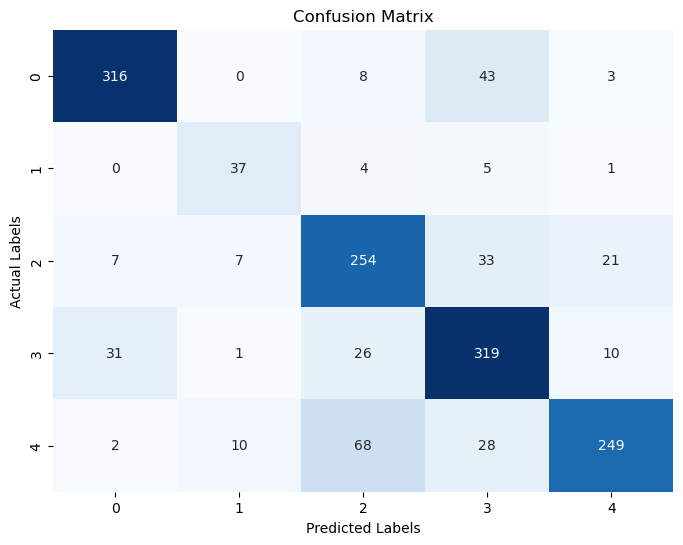

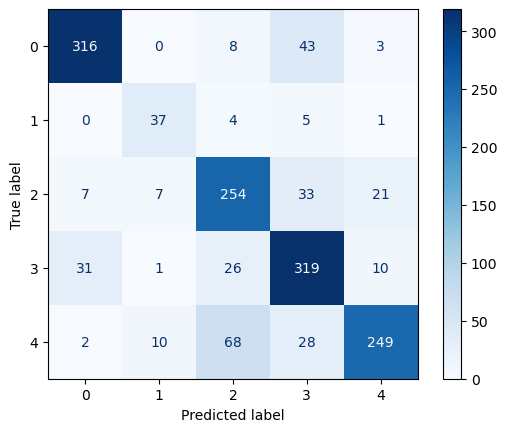

In [42]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
import seaborn as sns

# Predict the classes for the test set
y_pred_1 = model.predict(X_test_1)
y_pred_classes_1 = np.argmax(y_pred_1, axis=1)  # Convert predictions to class labels
y_true_1 = np.argmax(y_test_1, axis=1)  # Convert one-hot true labels to class labels

# Generate confusion matrix
cm = confusion_matrix(y_true_1, y_pred_classes_1)

# Plot confusion matrix using seaborn or matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Alternative using ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap='Blues')
plt.show()


In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM

tf.keras.backend.clear_session()
#from sklearn.metrics import plot_confusion_matrix
from sklearn import datasets, tree, linear_model, svm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import GRU


In [44]:

path_csv = os.path.expanduser('/home/mahin/Documents/notebook/Multimodal-Emotion-Recognition/Datasets/EEG/emotions.csv')


for dirname, _, filenames in os.walk(path_csv):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#Reading dataset
EEGData = pd.read_csv(path_csv)


#! Seprarting Positive,Neagtive and Neutral dataframes for plortting
pos = EEGData.loc[EEGData["label"]=="POSITIVE"]
sample_pos = pos.loc[2, 'fft_0_b':'fft_749_b']
neg = EEGData.loc[EEGData["label"]=="NEGATIVE"]
sample_neg = neg.loc[0, 'fft_0_b':'fft_749_b']
neu = EEGData.loc[EEGData["label"]=="NEUTRAL"]
sample_neu = neu.loc[1, 'fft_0_b':'fft_749_b']

def Transform_data(EEGData):
    #Encoding Lables into numbers
    encoding_data = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} )
    data_encoded = EEGData.replace(encoding_data)
    x = data_encoded.drop(["label"]  ,axis=1)
    y = data_encoded.loc[:,'label'].values
    scaler = StandardScaler()
    scaler.fit(x)
    X_scaled = scaler.transform(x)
    X_raw = x.values.astype(np.float32)
    Y = to_categorical(y)
    return X_scaled, Y, X_raw


X_scaled, Y, eeg_raw_signals = Transform_data(EEGData)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X_scaled, Y, test_size = 0.2, random_state = 4)


#! Reshape the data to fit the RNN input shape
x_train_2 = np.expand_dims(x_train_2, axis=-1)
x_test_2 = np.expand_dims(x_test_2, axis=-1)

/tmp/ipykernel_361795/1717476355.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_encoded = EEGData.replace(encoding_data)


In [45]:
speech_general_mapping = {
    0: 2,  # Angry -> Negative
    1: 1,  # Calm -> Positive
    2: 0,  # Neutral -> Neutral
    3: 1,  # Happy -> Positive
    4: 2   # Sad -> Negative
}

if 'y' not in globals():
    raise RuntimeError("Speech label array 'y' is required before generating advanced sequences.")

if y.ndim == 2:
    label_indices = np.argmax(y, axis=1)
else:
    label_indices = y.astype(int)

advanced_speech_sequences = []
advanced_eeg_sequences = []
fusion_labels_general = []

min_samples = min(len(speech_file_paths), len(eeg_raw_signals))
print(f"Aligning first {min_samples} samples across speech and EEG modalities")

for idx in range(min_samples):
    speech_path = speech_file_paths[idx]
    speech_feat = preprocess_speech_file(speech_path, target_sr=16000, n_mfcc=40, hop_length=256)
    eeg_vector = eeg_raw_signals[idx]
    eeg_feat = preprocess_eeg_sample(eeg_vector, fs=128, window_size=128, step=64)
    advanced_speech_sequences.append(speech_feat)
    advanced_eeg_sequences.append(eeg_feat)
    fusion_labels_general.append(speech_general_mapping[int(label_indices[idx])])

advanced_speech_sequences = np.array(advanced_speech_sequences, dtype=object)
advanced_eeg_sequences = np.array(advanced_eeg_sequences, dtype=object)
fusion_labels_general = np.array(fusion_labels_general)

/home/mahin/anaconda3/envs/cooolenv/lib/python3.12/site-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/home/mahin/anaconda3/envs/cooolenv/lib/python3.12/site-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/home/mahin/anaconda3/envs/cooolenv/lib/python3.12/site-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/home/mahin/anaconda3/envs/cooolenv/lib/python3.12/site-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


Aligning first 2132 samples across speech and EEG modalities


/home/mahin/anaconda3/envs/cooolenv/lib/python3.12/site-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/home/mahin/anaconda3/envs/cooolenv/lib/python3.12/site-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/home/mahin/anaconda3/envs/cooolenv/lib/python3.12/site-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/home/mahin/anaconda3/envs/cooolenv/lib/python3.12/site-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
/home/mahin/anaconda3/envs/cooolenv/lib/python3.12/site-packages/scipy/signal/_signaltools.py:1783: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/home/mahin/anaconda3/envs/cooolenv/lib/python3.12/site-packages/scipy/signal/_signaltools.py

In [46]:
def dtw_align_pair(speech_seq: np.ndarray, eeg_seq: np.ndarray):
    """Align speech and EEG feature sequences using DTW."""
    speech_arr = np.asarray(speech_seq, dtype=np.float32)
    eeg_arr = np.asarray(eeg_seq, dtype=np.float32)

    if speech_arr.ndim == 1:
        speech_arr = speech_arr[:, None]
    elif speech_arr.ndim > 2:
        speech_arr = speech_arr.reshape(speech_arr.shape[0], -1)

    if eeg_arr.ndim == 1:
        eeg_arr = eeg_arr[:, None]
    elif eeg_arr.ndim > 2:
        eeg_arr = eeg_arr.reshape(eeg_arr.shape[0], -1)

    speech_alignment = np.linalg.norm(speech_arr, axis=1, keepdims=True).T
    eeg_alignment = np.linalg.norm(eeg_arr, axis=1, keepdims=True).T

    _, wp = librosa.sequence.dtw(X=speech_alignment, Y=eeg_alignment, metric="euclidean")
    wp = np.array(wp[::-1])

    aligned_speech = speech_arr[wp[:, 0]]
    aligned_eeg = eeg_arr[wp[:, 1]]
    return aligned_speech, aligned_eeg


def resample_aligned_sequences(speech_seq: np.ndarray, eeg_seq: np.ndarray, target_len: int):
    speech_resampled = signal.resample(speech_seq.astype(np.float32), target_len, axis=0)
    eeg_resampled = signal.resample(eeg_seq.astype(np.float32), target_len, axis=0)
    return speech_resampled.astype(np.float32), eeg_resampled.astype(np.float32)

In [47]:
dtw_speech_sequences = []
dtw_eeg_sequences = []
dtw_lengths = []
dtw_labels = []
skipped_indices = []

for idx, (speech_seq, eeg_seq, label) in enumerate(zip(advanced_speech_sequences, advanced_eeg_sequences, fusion_labels_general)):
    if speech_seq is None or eeg_seq is None:
        skipped_indices.append(idx)
        continue
    if len(speech_seq) == 0 or len(eeg_seq) == 0:
        skipped_indices.append(idx)
        continue
    try:
        aligned_speech, aligned_eeg = dtw_align_pair(speech_seq, eeg_seq)
        if aligned_speech.shape[0] < 4 or aligned_eeg.shape[0] < 4:
            skipped_indices.append(idx)
            continue
        dtw_speech_sequences.append(aligned_speech)
        dtw_eeg_sequences.append(aligned_eeg)
        dtw_lengths.append(aligned_speech.shape[0])
        dtw_labels.append(label)
    except Exception as err:
        print(f"DTW failed on index {idx}: {err}")
        skipped_indices.append(idx)


dtw_lengths = np.array(dtw_lengths)
print(f"DTW alignment complete. Successful pairs: {len(dtw_speech_sequences)} | Skipped: {len(skipped_indices)}")
if len(dtw_lengths) > 0:
    suggested_length = int(np.clip(np.percentile(dtw_lengths, 75), 80, 320))
else:
    suggested_length = 120
print(f"Suggested target sequence length for resampling: {suggested_length}")

DTW alignment complete. Successful pairs: 2132 | Skipped: 0
Suggested target sequence length for resampling: 113


In [48]:
target_sequence_length = suggested_length
resampled_speech_sequences = []
resampled_eeg_sequences = []
resampled_labels = []

for speech_seq, eeg_seq, label in zip(dtw_speech_sequences, dtw_eeg_sequences, dtw_labels):
    speech_resampled, eeg_resampled = resample_aligned_sequences(speech_seq, eeg_seq, target_sequence_length)
    resampled_speech_sequences.append(speech_resampled)
    resampled_eeg_sequences.append(eeg_resampled)
    resampled_labels.append(label)

resampled_speech_sequences = np.array(resampled_speech_sequences, dtype=np.float32)
resampled_eeg_sequences = np.array(resampled_eeg_sequences, dtype=np.float32)
resampled_labels = np.array(resampled_labels)

print("Speech sequences shape:", resampled_speech_sequences.shape)
print("EEG sequences shape:", resampled_eeg_sequences.shape)
print("Labels shape:", resampled_labels.shape)

Speech sequences shape: (2132, 113, 120)
EEG sequences shape: (2132, 113, 2)
Labels shape: (2132,)


In [49]:
fusion_labels_onehot = to_categorical(resampled_labels, num_classes=3)

fusion_speech_train, fusion_speech_val, fusion_eeg_train, fusion_eeg_val, fusion_y_train, fusion_y_val = train_test_split(
    resampled_speech_sequences,
    resampled_eeg_sequences,
    fusion_labels_onehot,
    test_size=0.2,
    random_state=42,
    stratify=resampled_labels
 )

print("Fusion train speech shape:", fusion_speech_train.shape)
print("Fusion val speech shape:", fusion_speech_val.shape)
print("Fusion train EEG shape:", fusion_eeg_train.shape)
print("Fusion val EEG shape:", fusion_eeg_val.shape)
print("Fusion train labels shape:", fusion_y_train.shape)

Fusion train speech shape: (1705, 113, 120)
Fusion val speech shape: (427, 113, 120)
Fusion train EEG shape: (1705, 113, 2)
Fusion val EEG shape: (427, 113, 2)
Fusion train labels shape: (1705, 3)


In [50]:
print("DTW sequences count:", len(dtw_speech_sequences))
print("Skipped indices count:", len(skipped_indices))
print("Example advanced speech shape:", advanced_speech_sequences[0].shape if len(advanced_speech_sequences) else None)
print("Example EEG shape:", advanced_eeg_sequences[0].shape if len(advanced_eeg_sequences) else None)

DTW sequences count: 2132
Skipped indices count: 0
Example advanced speech shape: (117, 40, 3)
Example EEG shape: (38, 2)


In [51]:
test_idx = 0
speech_example = advanced_speech_sequences[test_idx]
eeg_example = advanced_eeg_sequences[test_idx]
speech_arr = np.asarray(speech_example)
eeg_arr = np.asarray(eeg_example)
if speech_arr.ndim == 1:
    speech_arr_proc = speech_arr[:, None]
elif speech_arr.ndim > 2:
    speech_arr_proc = speech_arr.reshape(speech_arr.shape[0], -1)
else:
    speech_arr_proc = speech_arr
if eeg_arr.ndim == 1:
    eeg_arr_proc = eeg_arr[:, None]
elif eeg_arr.ndim > 2:
    eeg_arr_proc = eeg_arr.reshape(eeg_arr.shape[0], -1)
else:
    eeg_arr_proc = eeg_arr
print("Processed speech shape:", speech_arr_proc.shape)
print("Processed EEG shape:", eeg_arr_proc.shape)
print("Transposed speech shape:", speech_arr_proc.T.shape)
print("Transposed EEG shape:", eeg_arr_proc.T.shape)
try:
    test_aligned_speech, test_aligned_eeg = dtw_align_pair(speech_example, eeg_example)
    print("Test aligned shapes:", test_aligned_speech.shape, test_aligned_eeg.shape)
except Exception as err:
    print("DTW error for test sample:", err)

Processed speech shape: (117, 120)
Processed EEG shape: (38, 2)
Transposed speech shape: (120, 117)
Transposed EEG shape: (2, 38)
Test aligned shapes: (117, 120) (117, 2)


In [52]:
def create_improved_model():
    # Input layer of model for brain signals
    inputs = tf.keras.Input(shape=(x_train_2.shape[1], x_train_2.shape[2]))
    
    # Add Bidirectional GRU layers directly on the 2D sequence input
    gru = Bidirectional(GRU(64, return_sequences=True))(inputs)
    gru = BatchNormalization()(gru)
    gru = Dropout(0.3)(gru)  # Dropout for regularization
    
    gru = Bidirectional(GRU(128, return_sequences=True))(gru)
    gru = BatchNormalization()(gru)
    gru = Dropout(0.3)(gru)
    
    gru = Bidirectional(GRU(64, return_sequences=False))(gru)
    gru = BatchNormalization()(gru)
    gru = Dropout(0.3)(gru)
    
    # Flatten the GRU output
    flatten = Flatten()(gru)
    
    # Fully connected layer with ReLU activation
    dense = Dense(128, activation='relu')(flatten)
    dense = Dropout(0.3)(dense)  # Dropout for regularization
    
    # Output layer (3 classes: Neutral, Positive, Negative) with softmax activation
    outputs = Dense(3, activation='softmax')(dense)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model

In [53]:
# Define a callback for TensorBoard
tensorboard_callback = TensorBoard(log_dir='./logs_2')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=1, mode='auto',
                               baseline=None, restore_best_weights=True)

#cretaing model
grumodel = create_improved_model()
#Compiling model
grumodel.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2548, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 2548, 128)      │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2548, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2548, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 2548, 256)      │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2548, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2548, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,467 (1.40 MB)

 Trainable params: 365,443 (1.39 MB)

 Non-trainable params: 1,024 (4.00 KB)

None


In [54]:
# Train the model
history = grumodel.fit(
    x_train_2, y_train_2,
    validation_data=(x_test_2, y_test_2),
    epochs=50, 
    batch_size=256,
    callbacks=[early_stopping, tensorboard_callback]
  )

#Save the model
grumodel.save('my_model_gru.h5')

#Evaluate the model on test data
test_loss, test_acc = grumodel.evaluate(x_test_2, y_test_2)

print('Test accuracy:', test_acc)

Epoch 1/50


7/7 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - accuracy: 0.3906 - loss: 1.4687 - val_accuracy: 0.6464 - val_loss: 1.0836
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 71s 9s/step - accuracy: 0.3906 - loss: 1.4687 - val_accuracy: 0.6464 - val_loss: 1.0836
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - accuracy: 0.5971 - loss: 0.9690 - val_accuracy: 0.7026 - val_loss: 1.0636
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - accuracy: 0.5971 - loss: 0.9690 - val_accuracy: 0.7026 - val_loss: 1.0636
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - accuracy: 0.6669 - loss: 0.8083 - val_accuracy: 0.7283 - val_loss: 1.0470
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - accuracy: 0.6669 - loss: 0.8083 - val_accuracy: 0.7283 - val_loss: 1.0470
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - accuracy: 0.7155 - loss: 0.7189 - val_accuracy: 0.7424 - val_loss: 1.0336
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - accuracy: 0.7155 - loss: 0.7189 - val_accuracy: 0.7424 - val_loss: 1.0336
Epoch 5/50
7/7 ━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 511ms/step - accuracy: 0.7471 - loss: 1.0155
Test accuracy: 0.7470725774765015
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 511ms/step - accuracy: 0.7471 - loss: 1.0155
Test accuracy: 0.7470725774765015


14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 562ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 562ms/step


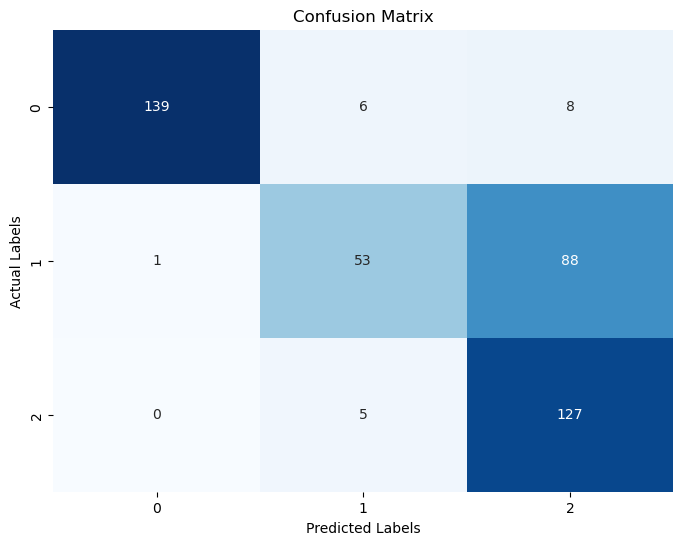

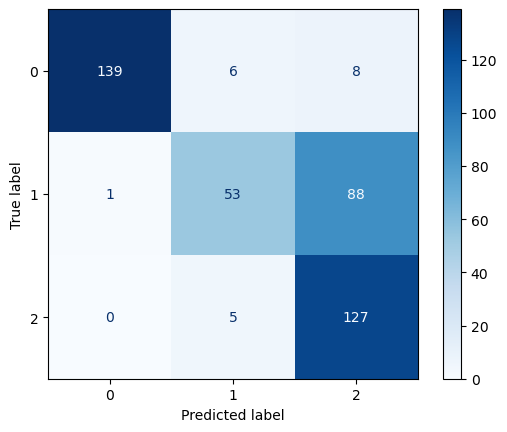

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
import seaborn as sns

# Predict the classes for the test set
y_pred = grumodel.predict(x_test_2)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_2, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn or matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Alternative using ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap='Blues')
plt.show()

In [56]:
from tensorflow.keras.layers import Concatenate, Dense, Input, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

def clone_with_prefix(base_model, prefix):
    cloned = tf.keras.models.clone_model(base_model)
    cloned.set_weights(base_model.get_weights())
    for layer in cloned.layers:
        layer._name = f"{prefix}_{layer.name}"
    cloned.trainable = False
    return cloned

# Use the already trained speech and EEG subnetworks
speech_model = clone_with_prefix(model, "speech")  # Speech CNN-LSTM
eeg_model = clone_with_prefix(grumodel, "eeg")     # EEG BiGRU

# Functional inputs for each modality
speech_input = Input(shape=speech_model.input_shape[1:], name="speech_input")
eeg_input = Input(shape=eeg_model.input_shape[1:], name="eeg_input")

# Forward pass through frozen subnetworks to obtain logits
speech_output = speech_model(speech_input)
eeg_output = eeg_model(eeg_input)

# Fuse logits/features and learn a lightweight classifier
combined = Concatenate(name="fusion_concat")([speech_output, eeg_output])
fusion_hidden = Dense(256, activation='relu', name="fusion_dense")(combined)
fusion_hidden = Dropout(0.3, name="fusion_dropout")(fusion_hidden)
final_output = Dense(y_train_1.shape[1], activation='softmax', name="fusion_classifier")(fusion_hidden)

multimodal_model = Model(inputs=[speech_input, eeg_input], outputs=final_output, name="multimodal_fusion")
multimodal_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
 )

multimodal_model.summary()

# Align datasets across modalities by trimming to the minimum available samples
min_train = min(len(X_train_1), len(x_train_2))
min_test = min(len(X_test_1), len(x_test_2))

speech_train = X_train_1[:min_train]
speech_test = X_test_1[:min_test]
labels_train = y_train_1[:min_train]
labels_test = y_test_1[:min_test]

eeg_train = x_train_2[:min_train]
eeg_test = x_test_2[:min_test]

# Expand speech inputs with a channel dimension if required by the CNN-LSTM branch
if speech_model.input_shape[-1] == 1 and speech_train.ndim == 3:
    speech_train = speech_train[..., np.newaxis]
    speech_test = speech_test[..., np.newaxis]

fusion_tensorboard = TensorBoard(
    log_dir='./logs_multimodal',
    histogram_freq=1,
    write_graph=True,
    update_freq='epoch'
 )

fusion_early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    min_delta=1e-3,
    restore_best_weights=True,
    verbose=1
 )

history_multimodal = multimodal_model.fit(
    [speech_train, eeg_train],
    labels_train,
    validation_data=([speech_test, eeg_test], labels_test),
    epochs=40,
    batch_size=256,
    callbacks=[fusion_early_stopping, fusion_tensorboard],
    verbose=1
 )

multimodal_model.save('multimodal_model.keras')

test_loss, test_acc = multimodal_model.evaluate([speech_test, eeg_test], labels_test, verbose=0)
print('Multimodal test accuracy:', test_acc)

Model: "multimodal_fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ speech_input        │ (None, 500, 40,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eeg_input           │ (None, 2548, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 5)         │  1,031,941 │ speech_input[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 3)         │    366,467 │ eeg_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_concat       │ (None, 8)         │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense        │ (None, 256)       │      2,304 │ fusion_concat[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dropout      │ (None, 256)       │          0 │ fusion_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_classifier   │ (None, 5)         │      1,285 │ fusion_dropout[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,401,997 (5.35 MB)

 Trainable params: 3,589 (14.02 KB)

 Non-trainable params: 1,398,408 (5.33 MB)

Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.1636 - loss: 1.6110 - val_accuracy: 0.2248 - val_loss: 1.6038
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.1636 - loss: 1.6110 - val_accuracy: 0.2248 - val_loss: 1.6038
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.1977 - loss: 1.5986 - val_accuracy: 0.2576 - val_loss: 1.5898
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.1977 - loss: 1.5986 - val_accuracy: 0.2576 - val_loss: 1.5898
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.2463 - loss: 1.5851 - val_accuracy: 0.2763 - val_loss: 1.5761
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.2463 - loss: 1.5851 - val_accuracy: 0.2763 - val_loss: 1.5761
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.2833 - loss: 1.5706 - val_accuracy: 0.3068 - val_loss: 1.5624
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.2833 - loss: 1.5706 - val_accuracy: 0.3068 - val_loss: 1.5624
Epoch 5/